## Intro

Welcome to our Machine learning project for the 2014 tech x change cohort. In this project we tackle the multilanguage toxic comments challenge from kaggle where we need to try and classify toxic comments while reducing bias and in classify toxic comments in other languages besides english.

In [ ]:
"""
Kaggle Link:
https://www.kaggle.com/competitions/jigsaw-multilingual-toxic-comment-classification/overview

"""

'\nKaggle Link:\nhttps://www.kaggle.com/competitions/jigsaw-multilingual-toxic-comment-classification/overview\n\n'

In [ ]:
"""
Idea/Thoughts Board
"""

#################################################################
## How to use the unintended bias columns to reduce bias
## Add callbacks to each model
## Adding weight
#################################################################

'\nIdea/Thoughts Board\n'

# Imports

In [ ]:
""" Check If Modules Already installed"""
get_py = get_ipython()

# Checks if transformers installed
if list(get_py.getoutput(f'pip show transformers'))[-1] == '\x1b[0m':
  !pip install transformers==4.37.2

In [ ]:
""" Import Modules """

# Data processing/visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import json
from google.colab import drive

# Building model
import tensorflow as tf
from tensorflow.nn import embedding_lookup
from tensorflow import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import metrics
from gensim.models import KeyedVectors
!pip install transformers==4.37.2
from transformers import TFAutoModel, AutoTokenizer, AutoModel, TFBertModel

# Training/Testing
## import keras_tuner as kt
from keras.callbacks import *
from keras.optimizers import Adam, SGD
from keras.regularizers import *
from keras.saving import load_model
from keras.optimizers.schedules import LearningRateSchedule
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

# TF Cloud Training
## import tensorflow_cloud as tfc # no time to implement

# Other
import sys
import os
import time
import zipfile


os.environ["SM_FRAMEWORK"] = "tf.keras"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


# Shortcut Google Drive Folder

**If you do not already have direct access to the data used, follow these steps. Otherwise, skip this section.**

Step 1: Login to Google Drive

Step 2: Go to the following Google Drive [link](https://drive.google.com/drive/folders/1gpu19MupiYL3__sE4QL-1B2KU_RqmJot?usp=sharing)

Step 3: Add the folder as a shortcut

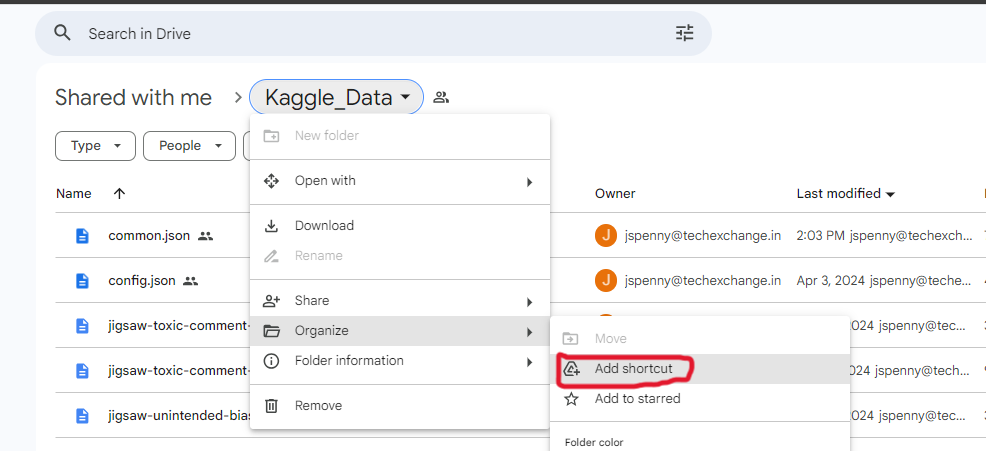

Step 4: Choose 'All locations', and click 'add' next to 'MyDrive'

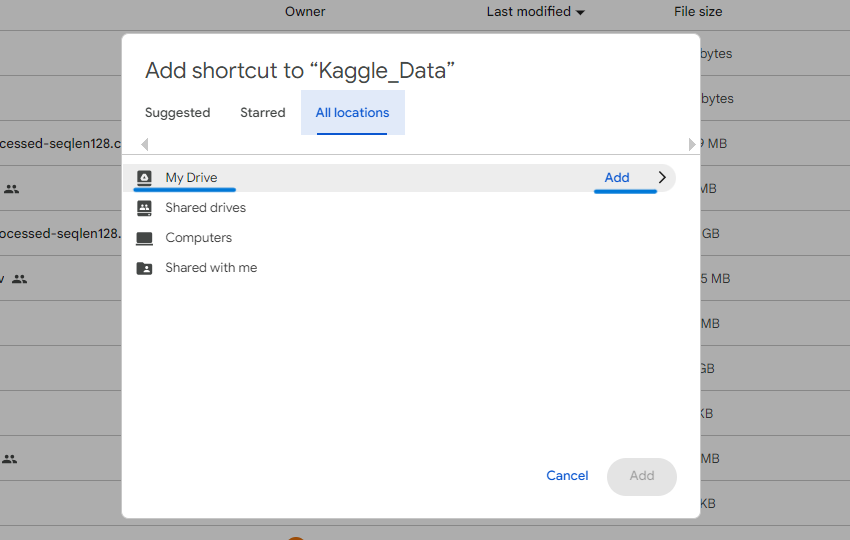

# Load Data

In [ ]:
""" Load Dataset From Drive """

# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

# Get data paths
data_path = '/content/drive/MyDrive/Kaggle_Data/'

if not os.path.exists(data_path):
  raise Exception("File path not found, ensure you added the shortcut in the correct drive i.e. 'MyDrive'")

data_list = os.listdir(data_path)

# Prompt for dataset to load
# data_choice = int(input("0: Train & Valid\n1: Test\n2: All\n>"))
data_choice = 0 # Temp

Mounted at /content/drive


In [ ]:
""" Loads Data """

# Training/Valid
x_train = pd.read_csv(data_path + 'jigsaw-toxic-comment-train.csv')
x_train_wbias = pd.read_csv(data_path + 'jigsaw-unintended-bias-train.csv')
x_valid = pd.read_csv(data_path + 'validation.csv')

#Testing
x_test = pd.read_csv(data_path + 'test.csv')
y_test = pd.read_csv(data_path + 'test_labels.csv')

# Analyzing and Preprocessing Data

## Initial Data Overview
We first want to visualize the initial state of the data we are going to work with. This will help us understand what data is irrelevant, revalvent, and/or needs to be adjusted.

In [ ]:
""" Data Overview """
x_train_wbias.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
""" Types of Data"""
x_train_wbias.dtypes

id                                       int64
comment_text                            object
toxic                                  float64
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float64
jewish                                 float64
latino                                 float64
male         

In [ ]:
""" Data Example """
x_train_wbias.loc[0]

id                                                                                 59848
comment_text                           This is so cool. It's like, 'would you want yo...
toxic                                                                                0.0
severe_toxicity                                                                      0.0
obscene                                                                              0.0
identity_attack                                                                      0.0
insult                                                                               0.0
threat                                                                               0.0
asian                                                                                NaN
atheist                                                                              NaN
bisexual                                                                             NaN
black                

In [ ]:
""" Convert Rating to Integers """
x_train_wbias['rating'] = x_train_wbias['rating'].map({'rejected':0, 'approved':1})

## Unnecessary Data
The following is removed as we don't want the model
to rely on Dates/IDs, or public reactions. These
can skew the predictions of the model, instead of having the model
focus directly on the contents of the comment itself.

In [ ]:
""" Dates & IDs """
dates_ids = x_train_wbias.loc[:, 'created_date':'article_id']
dates_ids.head()

,created_date,publication_id,parent_id,article_id
0,2015-09-29 10:50:41.987077+00,2,NaN,2006
1,2015-09-29 10:50:42.870083+00,2,NaN,2006
2,2015-09-29 10:50:45.222647+00,2,NaN,2006
3,2015-09-29 10:50:47.601894+00,2,NaN,2006
4,2015-09-29 10:50:48.488476+00,2,NaN,2006


In [ ]:
""" Removes Dates and IDs """
x_train_wbias.drop(dates_ids.columns, inplace=True, axis=1)
x_train_wbias.drop('id', inplace=True, axis=1)

In [ ]:
""" Public Reactions """
pub_react = x_train_wbias.loc[:, 'funny':'disagree']
pub_react.head()

,funny,wow,sad,likes,disagree
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,1,0


In [ ]:
""" Drops Public Reactions """
x_train_wbias.drop(pub_react.columns, inplace=True, axis=1)

## NaN Data
In machine learning, whenever you have missing data in crucial columns, one must evaluate whether to try and salvage the column, or remove it.

We noticed that plenty of rows were missing in some subgroups. Thankfully, when we inspected the data we noticed that Nan's could be interpreted as 0's, and we could salvage these rows to feed to our model.

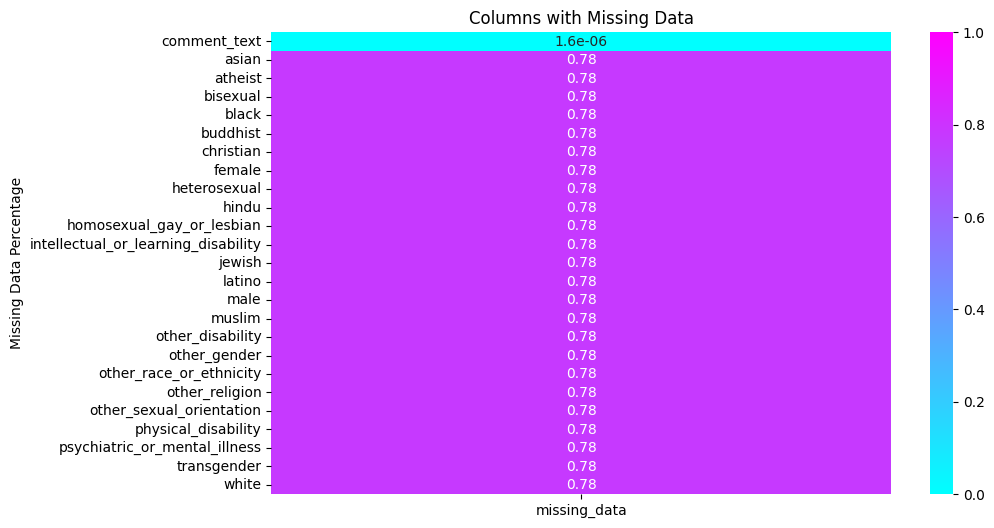

In [ ]:
""" Visualize NaN Data """

# Get missing value percent
nan_percent = x_train_wbias.isna().sum()/len(x_train_wbias)
nan_percent = nan_percent.reset_index()
nan_percent.columns = ['column_name', 'missing_data']

# Separate values with no NaNs
no_nans = nan_percent[nan_percent['missing_data'] == 0]
with_nans = nan_percent[nan_percent['missing_data'] > 0]

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(with_nans.set_index('column_name'), annot=True, cmap='cool', vmin=0, vmax=1)
plt.title('Columns with Missing Data')
plt.xlabel('')
plt.ylabel('Missing Data Percentage')
plt.show()

# # Create plot
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.bar(with_nans['column_name'], with_nans['missing_data'])

# # Isolate Non-NaN Columns
# ax.bar(['No NaN Columns'], [0.01], color='gray') # Is actually 0, but is 0.01 to show there is data here

# # Display Plot
# ax.set_xlabel('Column Name')
# ax.set_ylabel('NaN Percentage')
# ax.set_title('Percent of Missing Values per Column')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

In [ ]:
""" Replace/Remove NaNs in Data """

# Drops rows where 'comment_text' has NaN
x_train_wbias = x_train_wbias.dropna(subset=['comment_text'])

# Fills remaining NaN
# x_train_wbias = x_train_wbias.fillna(0.0)
# x_train_wbias.head()

In [ ]:
del nan_percent, no_nans, with_nans

## Toxic Data

Reviews and updates the toxic data

In [ ]:
""" Get Toxic Data """
toxic_df = x_train_wbias.loc[:, 'toxic':'threat']
toxic_df = toxic_df.join(x_train_wbias.loc[:, ['rating', 'sexual_explicit', 'toxicity_annotator_count']])
toxic_df.head()

,toxic,severe_toxicity,obscene,identity_attack,insult,threat,rating,sexual_explicit,toxicity_annotator_count
0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0,0.0,4
1,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0,0.0,4
2,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0,0.0,4
3,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0,0.0,4
4,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0,0.0,47


Visualize the relationship between the different types of toxicity (obscene, threat, etc)

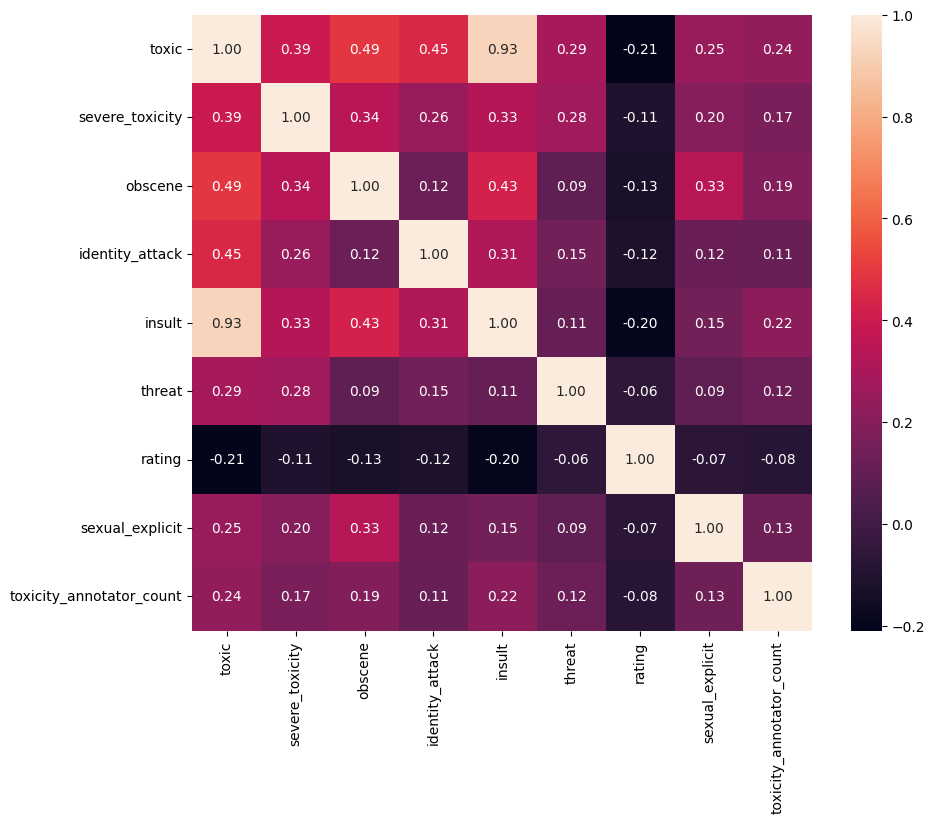

In [ ]:
""" Correlations of Toxic Data """

# Reduce repetitive info
toxic_df['toxicity_annotator_count'] -= 3

# Calculate corrs
corr_toxic = toxic_df.corr()

# Visualize corrs
plt.figure(figsize=(10,8))
sns.heatmap(corr_toxic, annot=True, fmt=".2f")
plt.show()

With this table we can see the disproportion between the positive and negative comments of the different types of toxicity we have in the dataset.

In [ ]:
""" Positive to Negative Toxicity """
len_data = len(toxic_df)

# Calculate pos to neg
threshold = 0
pos_counts = (toxic_df > threshold).sum()
neg_counts = len_data - pos_counts
ratio = pos_counts / neg_counts

# Display findings
count_df = pd.DataFrame({'Positive':pos_counts,
                         'Negative':neg_counts,
                         'Ratio':ratio},
                        index=toxic_df.columns)
count_df

,Positive,Negative,Ratio
toxic,569159,1333032,0.426966
severe_toxicity,110319,1791872,0.061566
obscene,155102,1747089,0.088777
identity_attack,230151,1672040,0.137647
insult,479129,1423062,0.336689
threat,112553,1789638,0.062891
rating,1775956,126235,14.068650
sexual_explicit,72611,1829580,0.039687
toxicity_annotator_count,1902138,53,35889.396226


In [ ]:
""" Drop Extra Columns """
toxic_df.drop(['rating', 'toxicity_annotator_count', 'sexual_explicit'], inplace=True, axis=1) #Dropped as it would add more time and complexity to the model training

In [ ]:
del  count_df, pos_counts, neg_counts, ratio, corr_toxic#, toxic_df, temp

## Unintended Bias
Reviews and updates the unintended bias data

In [ ]:
""" Get unintended bias data """
un_bias = x_train_wbias.loc[:, 'asian':'white']
un_bias = un_bias.join(x_train_wbias.loc[:, 'identity_annotator_count'])
un_bias.head()

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,...,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,identity_annotator_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In this table we measure the bias in the datasets between toxcity and the different subgroups. A higher "bias to toxic" than "bias to overall" suggests that a category is overrepresented in toxic comments compared to its general presence in the dataset, indicating potential bias.

In [ ]:
""" Quantify bias """

# Set thresholds (TH)
is_toxic_threshold = 0.5
is_bias_threshold = 0.1

# Get toxic comments based on TH
is_toxic = (toxic_df > is_toxic_threshold).any(axis=1)
is_toxic = is_toxic.to_frame(name='is_toxic')

# Get bias comments based on TH
is_bias = (un_bias > is_bias_threshold)
is_bias.drop('identity_annotator_count', axis=1, inplace=True)

# Filters out data based on 'is_toxic'
toxic_bias = pd.concat([is_toxic, is_bias], axis=1)
toxic_bias = toxic_bias[toxic_bias['is_toxic']]

# Calculates bias to toxicity
toxic_bias_mean = toxic_bias.mean() * 100
toxic_bias_mean.drop(['is_toxic'], inplace=True)

# Calculates bias to overall comments
bias_mean = is_bias.mean() * 100

# Display findings (% of bias label in toxic data compared to % of bias labels in all data)
dis_find = pd.DataFrame({'bias_to_toxic':toxic_bias_mean, 'bias_to_overall':bias_mean}, index=is_bias.columns)
dis_find

,bias_to_toxic,bias_to_overall
asian,0.654676,0.531545
atheist,0.144516,0.106614
bisexual,0.186304,0.121807
black,3.412672,1.007417
buddhist,0.069646,0.055147
christian,3.040935,3.274014
female,6.323890,3.837627
heterosexual,0.299479,0.128641
hindu,0.070517,0.059615
homosexual_gay_or_lesbian,2.340118,0.783150


In [ ]:
del is_toxic, is_bias, toxic_bias, toxic_bias_mean, bias_mean

## Comment Texts
Reviews and updates comment text data, and also creates the vectorizer.



Note: The following two cells were computationally/time expensive,
so the frequency counts, mean, std, etc, were ran once
and hard coded and/or saved/loaded.

In [ ]:
""" Save Vocab """

"""
# Add sos/eos tokens (Not Needed)
CLS = '[CLS] '
SEP = ' [SEP]'

x_train_wbias['comment_text'] = CLS + x_train_wbias['comment_text'] + SEP

# Vectorize comments data
token_text_dataset = np.array(x_train_wbias['comment_text'])

vectorize = TextVectorization()
vectorize.adapt(token_text_dataset)

# Save vocabulary to drive
vocab = vectorize.get_vocabulary()

with open('vocab.json', 'w') as j_file:
  json.dump(vocab, j_file)

!cp /content/vocab.json /content/drive/MyDrive/Kaggle_Data/
"""

"\n# Add sos/eos tokens (Not Needed)\nCLS = '[CLS] '\nSEP = ' [SEP]'\n\nx_train_wbias['comment_text'] = CLS + x_train_wbias['comment_text'] + SEP\n\n# Vectorize comments data\ntoken_text_dataset = np.array(x_train_wbias['comment_text'])\n\nvectorize = TextVectorization()\nvectorize.adapt(token_text_dataset)\n\n# Save vocabulary to drive\nvocab = vectorize.get_vocabulary()\n\nwith open('vocab.json', 'w') as j_file:\n  json.dump(vocab, j_file)\n\n!cp /content/vocab.json /content/drive/MyDrive/Kaggle_Data/\n"

In [ ]:
""" Count Frequency of Words """

"""
# Convert to TF Dataset
token_text_dataset = tf.data.Dataset.from_tensor_slices(token_text_dataset)
token_text_dataset = token_text_dataset.batch(512)

# Initialize
freq_count = Counter()
comment_lens = []

# Get frequencies of each comment
for batch in token_text_dataset:

  # Vectorize batch
  id_tokens = vectorizer(batch)
  id_np = id_tokens.numpy()

  # Get length comment
  row_len = np.sum(np.logical_and(id_1d != 0, id_1d != 1), axis=1)
  id_1d = id_np.flatten()

  # Get freq. of words
  comment_lens += list(row_len)
  freq_count.update(id_1d)

# Get top 50 most common words (i.e. stop words)
freq_co_dict = dict([(int(word), int(co)) for word, co in freq_count.most_common(50)])

# Save frequencies
with open('common.json', 'w') as j_file:
  json.dump(freq_co_dict, j_file)

!cp /content/common.json /content/drive/MyDrive/Kaggle_Data/
"""

"\n# Convert to TF Dataset\ntoken_text_dataset = tf.data.Dataset.from_tensor_slices(token_text_dataset)\ntoken_text_dataset = token_text_dataset.batch(512)\n\n# Initialize\nfreq_count = Counter()\ncomment_lens = []\n\n# Get frequencies of each comment\nfor batch in token_text_dataset:\n\n  # Vectorize batch\n  id_tokens = vectorizer(batch)\n  id_np = id_tokens.numpy()\n\n  # Get length comment\n  row_len = np.sum(np.logical_and(id_1d != 0, id_1d != 1), axis=1)\n  id_1d = id_np.flatten()\n\n  # Get freq. of words\n  comment_lens += list(row_len)\n  freq_count.update(id_1d)\n\n# Get top 50 most common words (i.e. stop words)\nfreq_co_dict = dict([(int(word), int(co)) for word, co in freq_count.most_common(50)])\n\n# Save frequencies\nwith open('common.json', 'w') as j_file:\n  json.dump(freq_co_dict, j_file)\n\n!cp /content/common.json /content/drive/MyDrive/Kaggle_Data/\n"

In [ ]:
""" Load Vocab """
vocab_path = '/content/drive/MyDrive/Kaggle_Data/vocab.json'

with open(vocab_path, 'r') as j_file:
  vocab = json.load(j_file)


The frequency of the words allows us to see the most common words found in the comments data. This information was used to remove the most frequent words as it can create a large amount of noise and can decrease model performance.

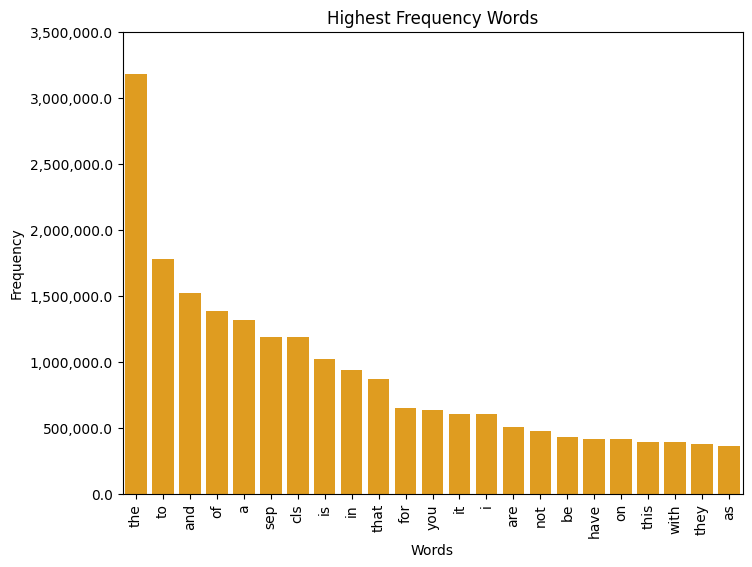

In [ ]:
""" Frequency of Words """

# Load most common words
with open('/content/drive/MyDrive/Kaggle_Data/common.json', 'r') as j_file:
  common_words = json.load(j_file)

r = 25 # Max of 50 (dont change)
words = [vocab[id] for id in range(2, r)]
counts = [common_words[str(id)] for id in range(2, r)]

# Display Frequency Findings
plt.figure(figsize=(8,6))
sns.barplot(x=words, y=counts, color='orange')
plt.xticks(rotation=90)
plt.yticks(plt.yticks()[0], [format(y, ',') for y in plt.yticks()[0]])

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Highest Frequency Words')

plt.show()

# Remove top words from the data
# vocab = [x for x in vocab if x not in words]

This normal distribution shows us that most of the comments have around 50 words. This was used to determine the max length of a sentence we should have when training, maximizing data coverage while minimizing noise and computational resources.

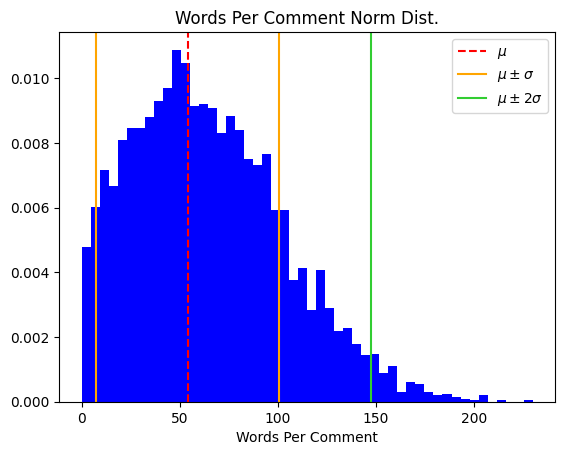

In [ ]:
""" # of Words Per Comment Normal Distribution """

# Create Norm Dist. Data
mean = 54.1
std = 46.6
norm_data = np.random.normal(mean, std, 5000)

# Filter out values below 0
norm_data = norm_data[norm_data >= 0]

# Display Graph
plt.hist(norm_data, bins=50, density=True, color='blue')
plt.xlabel("Words Per Comment")
plt.title("Words Per Comment Norm Dist.")

plt.axvline(x=mean, color='r', linestyle='--', label='$\mu$')
plt.axvline(x=mean + std, color='orange', linestyle='solid', label='$\mu \pm \sigma$')
plt.axvline(x=mean - std, color='orange', linestyle='solid')
plt.axvline(x=mean + 2*std, color='limegreen', linestyle='solid', label='$\mu \pm 2\sigma$')
# plt.axvline(x=mean - 2*std, color='limegreen', linestyle='solid')
plt.legend()

plt.show()

Text vectorizer allows us to convert our vocab into into a numerical format that machine learning algorithms can work with.

In [ ]:
""" Create Vectorizer """

# Set params for vectorizer
mt = 10_000 + r
max_length = int(mean + 2 * std) # Covers ~95% of data
vocab = vocab[:2] + vocab[r+1:mt]

# Create vectorizer
vectorizer = TextVectorization(vocabulary=vocab[:10_000],
                               max_tokens=mt,
                               output_mode='int',
                               output_sequence_length=max_length,
                               trainable=False)

# Models

## Baseline Model

A baseline model is a very simple model trained on the data and we use its performance as a metric we are trying to beat.

In this baseline model, we do a very simple Logistic regression with vectorization and embeddings of the comments with a global average max pooling at the end.

In [ ]:
""" Baseline Model for basic training data """

# Get accuracy based on num toxic labels
toxic_train = x_train['toxic']
tt_len = len(toxic_train)
acc = 1 - toxic_train.sum()/tt_len
print(f'Baseline model should have accuracy of around {acc*100:.2f}%')
# base_model = lambda x: [1 if np.random.rand() <= acc else 0 for i in range(len(x))]

Baseline model should have accuracy of around 90.43%


In [ ]:
def build_simple_model(vocab_size,
                       emb_dim,
                       max_len):

  # Reset TF and random seed (for reproducible results).
  keras.backend.clear_session()
  tf.random.set_seed(777)

  # Create sequential model
  model = Sequential([
      vectorizer,
      Embedding(
          input_dim=vocab_size,
          output_dim=emb_dim,
          input_length=max_len
      ),
      GlobalAveragePooling1D(),
      Dropout(0.5),
      Dense(
          units=1,
          use_bias=True,
          activation='sigmoid'
      )
  ])


  # Compile the model.
  model.compile(loss='binary_crossentropy',
                optimizer=SGD(),
                metrics=['accuracy', 'binary_accuracy', 'AUC'])

  return model

In [ ]:
""" Baseline Model """

# Build the model
simple_baseline_model = build_simple_model(
    vocab_size=len(vocab),
    emb_dim=2,
    max_len=max_length
)

# Training the model.
sample_x = 1_000
history = simple_baseline_model.fit(
  x = x_train['comment_text'][:sample_x],
  y = x_train['toxic'][:sample_x],
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=0
  )

# View history in pandas
history = pd.DataFrame(history.history)
history

,loss,accuracy,binary_accuracy,auc,val_loss,val_accuracy,val_binary_accuracy,val_auc
0,0.685462,0.784444,0.784444,0.502981,0.671828,0.9,0.9,0.500000
1,0.662775,0.894444,0.894444,0.486146,0.649875,0.9,0.9,0.405556
2,0.641836,0.894444,0.894444,0.556058,0.629510,0.9,0.9,0.500000
3,0.622370,0.894444,0.894444,0.523086,0.610659,0.9,0.9,0.500000
4,0.604469,0.894444,0.894444,0.521255,0.593964,0.9,0.9,0.500000


In [ ]:
""" Baseline Model Accuracy """
simple_eval = simple_baseline_model.evaluate(x = x_valid['comment_text'],
                                             y = x_valid['toxic'],
                                             batch_size=64,
                                             verbose=1)

eval_df = pd.DataFrame(simple_eval, columns=['value'], index=['loss', 'accuracy', 'bin_acc', 'AUC'])
eval_df

125/125 [==============================] - 5s 43ms/step - loss: 0.6086 - accuracy: 0.8462 - binary_accuracy: 0.8462 - auc: 0.5000


,value
loss,0.608607
accuracy,0.846250
bin_acc,0.846250
AUC,0.500000


The baseline models performance is pretty good, with an auc of over 0.50. Seems like it doesnt generalize well with new data. I think we can do better if we have some sort of smarter embeddings and use other techniques such as an attention mechanism.

## Expiremental Models
We explored 4 different types of models:

* Model based on the encoder from "Attention is all you need"  
* Transfer learning approach using the Bert model and our own layers
* Expands on the first model by adding a pre-trained multi-lingual embedding
* Ensemble model which combines the past 2 models

These models would allow us to attend to different types of complications when dealing with comments and toxic data.



### Model 1 pt.1
Learns context of training data and classifys comments based on the different types of toxicity (insult, threat, etc). Which is done through the encoder based model from "Attention is all you need".

The FFN is a custom feedforward network layer within a neural model, facilitating non-linear transformations of the input data in a transformer architecture.








In [ ]:
""" Custom Feed Forward Network Layer """

class FFN(Layer):
  def __init__(self, d_model, dff=None, dropout=0.35, **kwargs):
    # Call super and initialize layers
    super(FFN, self).__init__(**kwargs)
    self.d1 = Dense(dff if dff else d_model*4,
                    activation='relu')
    self.d2 = Dense(d_model,
                    kernel_regularizer=l2(),
                    bias_regularizer=l2())
    self.do = Dropout(dropout)

  def call(self, x):
    # Pass input through dense layers
    x = self.d1(x)
    x = self.do(x)
    x = self.d2(x)
    return x

  def get_config(self):
    return {'dense_1': self.d1,
            'dense_2': self.d2,
            'dropout': self.do}

The AddNorm class is a custom layer that combines a residual connection with a  normalization layer to the result to stabilize the training.

In [ ]:
""" Custom Add and Normalization Layer """

class AddNorm(Layer):
  def __init__(self, epsilon=1e-3, **kwargs):
    # Call super and initialize layers
    super(AddNorm, self).__init__(**kwargs)
    self.layer_norm = LayerNormalization(epsilon=epsilon,
                                         gamma_regularizer=l2(),
                                         beta_regularizer=l2())

  def call(self, input, output):
    # Normalize input and output
    x = input + output
    x = self.layer_norm(x)
    return x

  def get_config(self):
    return {'layer_norm': self.layer_norm}


The SubLayers class that processes input x through an attention mechanism and a feedforward network, both followed by an additive and normalization step.

In [ ]:
""" Creates Transormer Sublayers """
class SubLayers(Layer):
  def __init__(self, num_heads, key_dim, dropout=0.35, iter=0, **kwargs):
    # Call super and initialize layers
    super(SubLayers, self).__init__(**kwargs)#name=f"SubLayers_{iter}",
    self.mha = MultiHeadAttention(num_heads=num_heads,
                                  key_dim=key_dim,
                                  dropout=dropout)
    self.ffn = FFN(key_dim)
    self.an = AddNorm()

  def call(self, x):
    mask = tf.cast(tf.not_equal(x[:, :, 0], 0), dtype=tf.int32)
    mask = tf.expand_dims(mask, axis=1)
    mask = tf.expand_dims(mask, axis=1)

    # Pass x through Attention based sublayer
    x_out = self.mha(x, x, attention_mask=mask)
    x = self.an(x, x_out)

    # Pass x through FeedForwardNetwork based sublayer
    x_out = self.ffn(x)
    x = self.an(x, x_out)
    return x_out

  def get_config(self):
    return {'multi_att': self.mha,
            'ffn': self.ffn,
            'add_norm': self.an}


The PositionalEncoding generates a positional encoding matrix based on the sentence length and embedding dimensions, using a predefined maximum wavelength. When called, it adds this positional encoding to the input embeddings x to provide positional information to each token.

In [ ]:
class PositionalEncoding(Layer):
  def __init__(self, emb_dim, max_sent_len, max_wavelen=10_000, **kwargs):
    # Call super and initialize params
    super(PositionalEncoding, self).__init__(**kwargs)
    self.dim = emb_dim
    self.sent_len = np.arange(max_sent_len)[:, np.newaxis]
    self.wave_len = max_wavelen
    self.pos_enc = np.zeros((max_sent_len, emb_dim))

  def call(self, x):
    # Calculate positional encoding
    comp = self.wave_len ** (np.arange(0, self.dim, 2) / self.dim)
    self.pos_enc[:, ::2] = np.sin(self.sent_len / comp)
    self.pos_enc[:, 1::2] = np.cos(self.sent_len / comp)

    # Calculation from: https://colab.research.google.com/github/jaygala24/pytorch-implementations/blob/master/Attention%20Is%20All%20You%20Need.ipynb?authuser=2#scrollTo=mCTP_6UtTiMO
    """
    div_term = np.exp(np.arange(0, dim, 2) * -(np.log(10000.0) / 4))
    pos_enc_2 = np.zeros((length.size, dim))
    pos_enc_2[:, 0::2] = np.sin(length * div_term)
    pos_enc_2[:, 1::2] = np.cos(length * div_term)
    """

    # Add positional encoding to embedding(x)
    return x + self.pos_enc

  def get_config(self):
    return {'dim': self.dim,
            'sent': self.sent_len,
            'wave_len': self.wave_len,
            'pos_enc': self.pos_enc}

The AdamLR is a custom learning rate schedule for the Adam optimizer, where the learning rate is calculated based on the model dimension and a number of warmup steps.

In [ ]:
""" Custom Learning Rate for Adam Optimizer """
class AdamLR(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4, **kwargs):
    # Call super and initialize params
    super(AdamLR, self).__init__(**kwargs)
    self.dim = tf.Variable(float(d_model), dtype=tf.float32)
    self.wu = tf.Variable(float(warmup_steps), dtype=tf.float32)
    self.con5 = tf.constant(-0.5, dtype=tf.float32)
    self.con15 = tf.constant(-1.5, dtype=tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)

    z = self.dim ** self.con5
    x = step ** self.con5
    y = step * (self.wu ** self.con15)

    return z * tf.minimum(x, y)

  def get_config():
    return {'dim': self.dim,
            'warmup': self.wu,
            'con5': self.con5,
            'con15': self.con15}


Here we construct a transformer-based model suitable for nlp, utilizing a stack of transformer layers defined by parameters like number of layers, heads, and dropout rate.

In [ ]:
""" Create Toxic Model (Based on 'Attention Is All You Need') """
def build_transformer_encoder(vocab_size, emb_dim, max_len,
                              att_num_layers, att_num_heads,
                              num_targets):

    # Initial inputs
    input = Input((None,))

    # Create Embedding and add positional ids
    x = Embedding(input_dim=vocab_size,
                  output_dim=emb_dim,
                  mask_zero=True)(input)

    x = PositionalEncoding(emb_dim, max_len)(x)
    # x = SinePositionEncoding(...) # Doesnt work as it conflicts with bert transformer

    # Create sublayers
    for i in range(att_num_layers):
      x = SubLayers(att_num_heads,
                    emb_dim,
                    iter=i)(x)

    # Flatten and predict
    x = GlobalAveragePooling1D()(x) # x = Flatten()(x)
    output = Dense(num_targets,
                   use_bias=True,
                   activation='sigmoid')(x)

    model = Model(inputs=input, outputs=output, name='Toxicity_Context_Model')
    return model


In [ ]:
""" Build Toxic Model"""

# Build model
embed_dim = 32
toxic_model = build_transformer_encoder(
    vocab_size=len(vocab), emb_dim=embed_dim, max_len=max_length,
    att_num_layers=4, att_num_heads=16,
    num_targets=len(toxic_df.columns)
)

toxic_model.summary()

Model: "Toxicity_Context_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 32)          320032    
                                                                 
 positional_encoding (Posit  (None, 147, 32)           0         
 ionalEncoding)                                                  
                                                                 
 sub_layers (SubLayers)      (None, 147, 32)           75520     
                                                                 
 sub_layers_1 (SubLayers)    (None, 147, 32)           75520     
                                                                 
 sub_layers_2 (SubLayers)    (None, 147, 32)           75520     
                                            

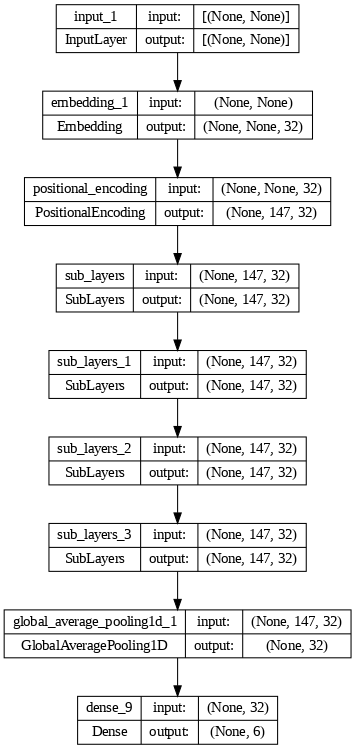

In [ ]:
""" Plot Toxic Model """
plot_model(toxic_model, show_shapes=True, dpi=75)

### Model 1 pt.2
Extends Model 1 by incorporating a pre-trained embedding with multilingual capability and expanding the current vocab.

Note: We tried using the fasttext embedding directly from the API but it allocated too much space, so we had to use a simple version which had minimal multilingual abilities.


Creates a new word embedding model based on the fasttext embedding, though with a limited vocabulary (top 25k words).

In [ ]:
""" Update Embedding """

"""
embed_path = data_path + 'multi_embed.bin'
multi_embed = KeyedVectors.load(embed_path)

print(f'Embedding Dimension: {multi_embed.vector_size}')

# Get vectors for each word
max_vocab_size = 25_000
dict_vectors = {}

# Add pad and unk to dict_vectors
dict_vectors['[PAD]'] = np.zeros((300,))
dict_vectors['[UNK]'] =  multi_embed.get_vector('UNK')

# Get vocab words and their vectors
for i in range(max_vocab_size):
  word = vocab[i]

  if word in multi_embed:
    dict_vectors[word] = multi_embed.get_vector(word)

# Create updated embedding
updated_embed = KeyedVectors(vector_size=300)
updated_embed.add_vectors(list(dict_vectors.keys()), list(dict_vectors.values()))

# Save updated embedding to drive
updated_embed_path = data_path + 'updated_multi_embed.bin'
updated_embed.save(updated_embed_path)
"""

"\nembed_path = data_path + 'multi_embed.bin'\nmulti_embed = KeyedVectors.load(embed_path)\n\nprint(f'Embedding Dimension: {multi_embed.vector_size}')\n\n# Get vectors for each word\nmax_vocab_size = 25_000\ndict_vectors = {}\n\n# Add pad and unk to dict_vectors\ndict_vectors['[PAD]'] = np.zeros((300,))\ndict_vectors['[UNK]'] =  multi_embed.get_vector('UNK')\n\n# Get vocab words and their vectors\nfor i in range(max_vocab_size):\n  word = vocab[i]\n\n  if word in multi_embed:\n    dict_vectors[word] = multi_embed.get_vector(word)\n\n# Create updated embedding\nupdated_embed = KeyedVectors(vector_size=300)\nupdated_embed.add_vectors(list(dict_vectors.keys()), list(dict_vectors.values()))\n\n# Save updated embedding to drive\nupdated_embed_path = data_path + 'updated_multi_embed.bin'\nupdated_embed.save(updated_embed_path)\n"

Loads the saved embedding from the previous cell and creates the embedding matrix with a new vectorizer based on such.

In [ ]:
""" Incorporate Updated Embedding/Tokenizer """

# Load embedding
updated_embed_path = data_path + 'updated_multi_embed.bin'
multi_embed = KeyedVectors.load(updated_embed_path)
emb_dim = multi_embed.vector_size

# Create embedding matrix
updated_vocab = list(multi_embed.key_to_index.keys())
embed_matrix = np.array([multi_embed.get_vector(word) for word in updated_vocab])
assert embed_matrix.shape[1] == 300

# Create updated tokenizer
updated_vec = TextVectorization(vocabulary=updated_vocab,
                                output_mode='int',
                                output_sequence_length=max_length,
                                trainable=False)

Custom embedding layer which uses custom weigths/embedding (as this was depricated in the newer versions of tf).

In [ ]:
class UpdatedEmbedding(Layer):
  def __init__(self, weights, **kwargs):
    # Call super and initialize params
    super(UpdatedEmbedding, self).__init__(**kwargs)
    # self.embedding = self.add_weight(
    #     shape=weights.shape,
    #     initializer=tf.constant_initializer(weights),
    #     trainable=False)
    self.embedding = weights

  def call(self, x):
    x = tf.cast(x, tf.int32)
    emb = embedding_lookup(self.embedding, x)
    return emb

  def get_config(self):
    config = super(UpdatedEmbedding, self).get_config()
    config.update({
      "custom_embedding": self.embedding
    })
    return config

In [ ]:
""" Create Multi-lingual Model """
def build_multi_ling_model(vocab_size, emb_dim, up_weights, max_len,
                           att_num_layers, att_num_heads,
                           num_targets):

  updated_emb = UpdatedEmbedding(weights=up_weights,
                                 trainable=False)

  # Get toxic model
  toxic_model = build_transformer_encoder(
      vocab_size=vocab_size, emb_dim=emb_dim, max_len=max_len,
      att_num_layers=att_num_layers, att_num_heads=att_num_heads,
      num_targets=num_targets
  )

  # Add updated embedding to toxic model
  multi_ling_model = Sequential([toxic_model.layers[0],
                                 updated_emb])#, name='Multi_lingual_Model'
  for layer in toxic_model.layers[2:]:
    multi_ling_model.add(layer)

  return multi_ling_model


In [ ]:
""" Build Multilingual Model"""

# Build model
multi_ling_model = build_multi_ling_model(
    vocab_size=len(updated_vocab), emb_dim=multi_embed.vector_size, up_weights=embed_matrix,
    max_len=max_length, att_num_layers=2, att_num_heads=4,
    num_targets=len(toxic_df.columns)
)

multi_ling_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 updated_embedding (Updated  (None, None, 300)         0         
 Embedding)                                                      
                                                                 
 positional_encoding_1 (Pos  (None, 147, 300)          0         
 itionalEncoding)                                                
                                                                 
 sub_layers_4 (SubLayers)    (None, 147, 300)          2166000   
                                                                 
 sub_layers_5 (SubLayers)    (None, 147, 300)          2166000   
                                                                 
 global_average_pooling1d_2  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                      

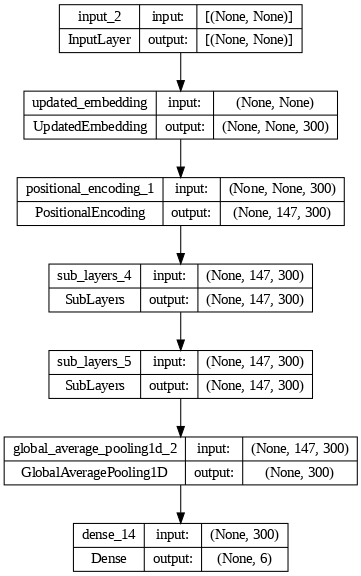

In [ ]:
""" Plot Multi-lingual Model """
plot_model(multi_ling_model, show_shapes=True, dpi=75)

### Model 2
The Bert model was initially suppsed to be used to reduce the unintended bias derived from models pt.1-2. Though after much effort, we were unable to use this model for that goal, so instead we used Bert as another type of model to predict the overall toxicity of a comment.


In this step we preprocess the comments in the dataframe to ensure our model correctly look at the right words and doesnt get boggled down by stop words or weird characters.

Since this step takes a long time, this was run once and saved in disk to then load the preprocessed dataframe.

In [ ]:
# preprocess comment_text

# df = x_train_wbias.copy()
# import re

# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

# # https://gist.github.com/sebleier/554280
# # we are removing the words from the stop words list: 'no', 'nor', 'not'
# stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
#             "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
#             'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
#             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
#             'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
#             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
#             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
#             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
#             'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
#             'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
#             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
#             've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
#             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
#             "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
#             'won', "won't", 'wouldn', "wouldn't", "cls", "sep"]

# preprocessed_comments = []
# for sentence in df['comment_text'].values:
#     sent = decontracted(sentence)
#     sent = sent.replace('\r', ' ')
#     sent = sent.replace('\"', ' ')
#     sent = sent.replace('\n', ' ')
#     sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
#     # https://gist.github.com/sebleier/554280
#     sent = ' '.join(e for e in sent.split() if e not in stopwords)
#     preprocessed_comments.append(sent.lower().strip())

# df['comment_text'] = preprocessed_comments

# df
#load preprocessed comments from file
df = pd.read_parquet(data_path + "bias.parquet")[:10_000] #capped to 1 mill due to resource constraints
df.head(3)

,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,rating,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,this cool it like would want mother read reall...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,4
1,thank this would make life lot less anxiety in...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,4
2,this urgent design problem kudos taking very i...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,4


convert probalities into true or false

In [ ]:
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness', 'asian'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
for column in IDENTITY_COLUMNS + ['toxic']:
    df[column] = np.where(df[column] >= 0.5, True, False)
df.head(3)

,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,rating,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,this cool it like would want mother read reall...,False,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,...,0.0,0.0,0.0,False,0.0,False,0,0.0,0,4
1,thank this would make life lot less anxiety in...,False,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,...,0.0,0.0,0.0,False,0.0,False,0,0.0,0,4
2,this urgent design problem kudos taking very i...,False,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,...,0.0,0.0,0.0,False,0.0,False,0,0.0,0,4


In [ ]:
train_df, val_df, y_train, y_cv = train_test_split(df, df['toxic'], test_size=0.0002, random_state=42)

We are using a preprocessed bert model to since it already has an understanding of words and embeddings and reduces our training time

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-4_H-256_A-4")
# tokens = tokenizer(train_df['comment_text'].to_list(), padding='max_length', truncation=True, max_length=128, return_tensors="tf")

In [ ]:
def build_bert_model():
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_masks = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_masks")

    # BERT layer
    bert_layer = bert_model(input_ids, attention_mask=attention_masks)[0]

    flatten_layer = tf.keras.layers.Flatten()(bert_layer)

    dense = tf.keras.layers.Dense(4, activation='relu')(flatten_layer)

    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    # Construct a new model
    model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)

    for layer in model.layers[:3]:
      layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# load the already trained, fine tuned model from disk
# bert_model = build_bert_model()
# theres a compatibility problem when installing keras_nlp
bert_model = keras.models.load_model(data_path+'bert_model', custom_objects={'TFBertModel': TFBertModel}, compile=False)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1117056   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   0          'attention_masks[0][0]']     
                             hidden_state=(None, 128, 2                                       

In [ ]:
bert_model = load_model(data_path+'bert_model', custom_objects={'TFBertModel': TFBertModel}, compile=False)

### Ensemble Model
Combines the previous models, such that they can be used to predict the overall toxicity of a comment at a higher precision/accuracy rate.

In [ ]:
def build_ensemble_model(models: list):
  if not isinstance(models, list):
    raise TypeError('Expected type list and/or list length > 1')

  # Intialize inputs
  input = Input(shape=(None,))

  # Pass input through all models
  x = [model(input) for model in models]

  # Transform features and concat outputs
  def feat_trans(y):
    y = Dense(32, activation='relu')(y)
    y = Dense(8, activation='relu')(y)
    return y
  x = [feat_trans(output) for output in x]

  # Concat model(s) output and predict
  x = Concatenate()(x)
  x = Dense(4, activation='relu')(x)
  output = Dense(1, activation='sigmoid')(x)

  ensemble_model = Model(inputs=input, outputs=output, name='Ensemble_Model')
  return ensemble_model

In [ ]:
""" Build Ensemble Model"""

# Temp model
temp_model = Sequential([
    Input((147, 32)),
    Dense(5, activation='relu')
])

# Build model
ensemble_model = build_ensemble_model(models=[multi_ling_model, temp_model])
ensemble_model.summary()

Model: "Ensemble_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 6)                    4333806   ['input_4[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 147, 5)               165       ['input_4[0][0]']             
                                                                                                  
 dense_16 (Dense)            (None, 32)                   224       ['sequential_1[0][0]']        
                                                                                     

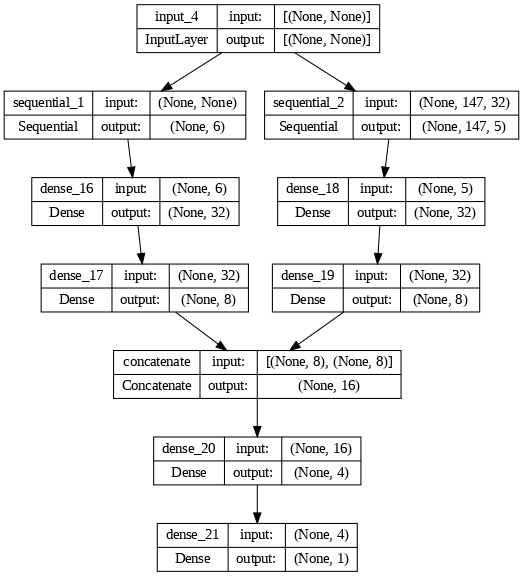

In [ ]:
""" Plot Ensemble Model """
plot_model(ensemble_model, show_shapes=True, dpi=75)

# Training/Testing

In [ ]:
def get_callbacks(model_name, pat_n=5, emb_freq=0):
  checkpoint = ModelCheckpoint(data_path + f'{model_name}.keras',
                               save_best_only=True)

  earlystop = EarlyStopping(monitor='val_loss',
                            patience=pat_n,
                            restore_best_weights=True)

  tensorboard = TensorBoard(log_dir=data_path + "tensor_board",
                            histogram_freq=5,
                            write_images=True,
                            write_steps_per_second=True,
                            update_freq="epoch",
                            embeddings_freq=emb_freq)

  return checkpoint, earlystop, tensorboard


## Bert Model

In [ ]:
""" Train Bert Model """

# Get training data
tokens = tokenizer(x_test['content'].to_list(), padding='max_length', truncation=True, max_length=128, return_tensors="tf")

# Compile model
opt = Adam()
bert_model.compile(optimizer=opt,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Train model
save_name = 'bert_model_1'
bert_hist = bert_model.fit(
    {"input_ids": tokens['input_ids'], "attention_masks": tokens['attention_mask']},
    y_train,
    epochs=1,  # BERT can benefit from more epochs
    batch_size=64, verbose=1,
    callbacks=get_callbacks(save_name)
)

# Store history
bert_hist_df = pd.DataFrame(bert_hist.history)
bert_hist_df.to_csv(data_path + f'{save_name}_df.csv', index=True)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

## Original Toxic Model

In [ ]:
""" Train Toxic Model """
# Initialize params for compile
opt = Adam(#learning_rate=AdamLR(embed_dim, warmup_steps=3),
           #beta_1=0.9,
           #beta_2=0.98,
           #epsilon=1e-09,
           )
auc = metrics.AUC(multi_label=True)

# Compile model
toxic_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[auc, 'accuracy'])

# Get training data
train_size = 1
x_data = vectorizer(x_train_wbias['comment_text'][:train_size].to_numpy())
y_data = toxic_df[:train_size].to_numpy()
x_val = vectorizer(x_valid['comment_text'][:train_size].to_numpy())
y_val = np.ones((train_size, len(toxic_df.columns))) * x_valid['toxic'][:train_size].to_numpy()[:, np.newaxis]

# Train model
save_name = 'toxic_model_2'
toxic_hist = toxic_model.fit(x_data, y_data,
                             validation_data=(x_val, y_val),
                             epochs=10, verbose=1,
                             batch_size=128,
                             callbacks=get_callbacks(save_name))

# Store history
toxic_hist_df = pd.DataFrame(toxic_hist.history)
toxic_hist_df.to_csv(data_path + f'{save_name}_df.csv', index=True)

## Mulit-Lingual Model

In [ ]:
""" Train Multi-Lingual Model """
# Initialize params for compile
opt = Adam(#learning_rate=AdamLR(embed_dim, warmup_steps=3),
           #beta_1=0.9,
           #beta_2=0.98,
           #epsilon=1e-09,
           )

auc = metrics.AUC(multi_label=True)

# Compile model
multi_ling_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[auc, 'accuracy'])

# Get training data
train_size = 1
x_data = vectorizer(x_train_wbias['comment_text'][:train_size].to_numpy())
y_data = toxic_df[:train_size].to_numpy()
x_val = vectorizer(x_valid['comment_text'][:train_size].to_numpy())
y_val = np.ones((train_size, len(toxic_df.columns))) * x_valid['toxic'][:train_size].to_numpy()[:, np.newaxis]

# Train model
save_name = 'multi_ling_model_1'
multi_ling_hist = multi_ling_model.fit(x_data, y_data,
                                       validation_data=(x_val, y_val),
                                       epochs=10, verbose=1,
                                       batch_size=128,
                                       callbacks=get_callbacks(save_name))

# Store history
multi_ling_hist_df = pd.DataFrame(multi_ling_hist.history)
multi_ling_hist_df.to_csv(data_path + f"{save_name}_df.csv", index=True)



# Error Analysis

In [ ]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix,index=class_names, columns=class_names
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [ ]:
print_confusion_matrix(confusion_matrix(preds > 0.4, y_test['toxic']), class_names=['NO','YES'])

In [ ]:
""" Load Multi-Lingual History Data"""

# Load history
multi_ling_hist = pd.read_csv(data_path + "multi_ling_hist_df.csv", index_col=0)
multi_ling_hist.rename(columns={'auc_4': 'auc', 'val_auc_4': 'val_auc'}, inplace=True)

# Separate training and validation history
multi_train_df = multi_ling_hist.iloc[:, :3]
multi_valid_df = multi_ling_hist.iloc[:, 3:]

# Display all history
multi_ling_hist

In [ ]:
""" Plot the history """

# Set figures and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Build training hist graph
for column in multi_train_df.columns:
    axes[0].plot(multi_train_df.index, multi_train_df[column], label=column)

axes[0].set_title("Progress of training")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Values")
axes[0].legend()

# Build validatin hist graph
for column in multi_valid_df.columns:
    axes[1].plot(multi_valid_df.index, multi_valid_df[column], label=column)

axes[1].set_title("Progress of validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Values")
axes[1].legend()

# Plot graphs
plt.tight_layout()
plt.show()

In [ ]:
""" Visualize Predictions """

# Apply a threshold to convert predictions to binary labels
threshold = 0.5
num = 1_000
preds = multi_ling_model.predict(vectorizer(x_test['content'][:num].to_numpy()))
bin_preds = np.any(preds >= threshold, axis=1) * 1
test = y_test[:num]['toxic'].to_numpy()

# Calculate TP, FP, FN, and TN
TP = np.sum((bin_preds == 1) & (test == 1))
FP = np.sum((bin_preds == 1) & (test == 0))
FN = np.sum((bin_preds == 0) & (test == 1))
TN = np.sum((bin_preds == 0) & (test == 0))

# Create the confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.show()

## Kaggle Submission

In [ ]:
# output .csv in kaggle format
def output_kaggle_test(preds, filename='preds.csv'):
  # make a copy of the test data (as a Pandas DataFrame)
  kaggle_df = x_test[['id']].copy()

  # replace the target column with your actual predictions
  kaggle_df['target'] = preds

  # convert the DataFrame to a .csv file and save it in colab
  # click on "folder" icon on left-hand menu bar to see it and download
  kaggle_df.to_csv(filename, index=False)

  # display portion of DataFrame as a sanity check
  # that it is formatted correctly
  display(kaggle_df)

In [ ]:
output_kaggle_test(preds, filename='submission.csv')

# One-Time Setup

In [ ]:
""" Download Kaggle Data """

# Upload kaggle API key
from google.colab import files
files.upload()  # Uploads kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c jigsaw-multilingual-toxic-comment-classification

# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify Paths
colab_folder = '/content/kaggle_data'
drive_folder = '/content/drive/MyDrive/Kaggle_Data'
path = '/content/jigsaw-multilingual-toxic-comment-classification.zip'
extract_to = '/content/kaggle_data'

# Extract files from .zip
import zipfile

with zipfile.ZipFile(path, 'r') as zipped:
  zipped.extractall(extract_to)

# Upload data to Drive
!cp -r "$colab_folder"/* "$drive_folder"/

In [ ]:
""" Load FastText Embedding (Attempted the following but used too much ram) """

"""
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')
fasttext.util.reduce_model(ft, 100)
"""

In [ ]:
""" Load FastText Embedding """

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Load embedding into model
vec_embed_path = '/content/drive/MyDrive/Kaggle_Data/wiki-news-300d-1M-subword.vec'

from gensim.models import KeyedVectors
vec_multi_embed = KeyedVectors.load_word2vec_format(vec_embed_path)

# Save mmodel to drive
vec_multi_embed.save('/content/drive/MyDrive/Kaggle_Data/multi_embed.bin')


# Sources

https://arxiv.org/pdf/1706.03762.pdf

https://storage.googleapis.com/gweb-research2023-media/pubtools/pdf/ab50a4205513d19233233dbdbb4d1035d7c8c6c2.pdf

https://arxiv.org/pdf/1903.04561.pdf